# Age at first marriage

Comparing results from NSFG and IPUMS data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shelve

from lifelines import KaplanMeierFitter

from utils import decorate
from utils import values
from utils import resample_rows_weighted
from utils import round_into_bins

from empiricaldist import Pmf, Cdf

random_seed = 12

In [2]:
def set_palette(*args, **kwds):
    """Set the matplotlib color cycler.
    
    args, kwds: same as for sns.color_palette
    
    Also takes a boolean kwd, `reverse`, to indicate
    whether the order of the palette should be reversed.
    
    returns: list of colors
    """
    reverse = kwds.pop('reverse', False)
    palette = sns.color_palette(*args, **kwds)
    
    palette = list(palette)
    if reverse:
        palette.reverse()
        
    cycler = plt.cycler(color=palette)
    plt.gca().set_prop_cycle(cycler)
    return palette

In [3]:
def plot_kmf_map(kmf_map, cohorts, **options):
    """
    """
    fig, ax = plt.subplots()
    palette = set_palette('hls', len(cohorts))
    for cohort in cohorts:
        series = kmf_map[cohort]
        series.plot(ax=ax, label=f'{cohort+1900}s')

    decorate(xlabel='Age (years)',
             ylabel='Percent ever married',
             xlim=[13, 55], 
             **options,
             )
    
    ax.legend(title='Decade of birth', loc='lower right')

## NSFG original analysis

Get the curves computed in marriage.ipynb

In [4]:
def PercentileRow(array, p):
    """Selects the row from a sorted array that maps to percentile p.

    p: float 0--100

    returns: NumPy array (one row)
    """
    rows, cols = array.shape
    index = int(rows * p / 100)
    return array[index,]

In [5]:
def PercentileRows(ys_seq, percents):
    """Given a collection of lines, selects percentiles along vertical axis.

    For example, if ys_seq contains simulation results like ys as a
    function of time, and percents contains (5, 95), the result would
    be a 90% CI for each vertical slice of the simulation results.

    ys_seq: sequence of lines (y values)
    percents: list of percentiles (0-100) to select

    returns: list of NumPy arrays, one for each percentile
    """
    nrows = len(ys_seq)
    ncols = len(ys_seq[0])
    array = np.zeros((nrows, ncols))

    for i, ys in enumerate(ys_seq):
        array[i,] = ys

    array = np.sort(array, axis=0)

    rows = [PercentileRow(array, p) for p in percents]
    return rows

In [6]:
def MakeSurvivalCI(sf_seq, percents, flip=False):
    """Makes confidence intervals from a list of survival functions.

    sf_seq: list of SurvivalFunction
    percents: list of percentiles to select, like [5, 95]

    returns: (ts, rows) where ts is a sequence of times and
             rows contains one row of values for each percent
    """
    # find the union of all ts where the sfs are evaluated
    ts = set()
    for sf in sf_seq:
        ts |= set(sf.ts)

    ts = list(ts)
    ts.sort()

    # evaluate each sf at all times
    if flip:
        ys = 1-sf.Probs(ts)
    else:
        ys = sf.Probs(ts)
    ss_seq = [100*ys for sf in sf_seq if len(sf) > 0]

    # return the requested percentiles from each column
    rows = PercentileRows(ss_seq, percents)
    return ts, rows

In [7]:
def PlotSurvivalFunctions(sf_map):
    """Plot estimated survival functions.

    sf_map: map from group name to sequence of survival functions
    predict_flag: whether the lines are predicted or actual
    colormap: map from group name to color
    """
    for name, sf_seq in sorted(sf_map.items(), reverse=False):
        if len(sf_seq) == 0:
            continue

        sf = sf_seq[0]
        if len(sf) == 0:
            continue

        ts, rows = MakeSurvivalCI(sf_seq, [50])
        plt.plot(ts, 100-rows[0], label='19%ds'%name, alpha=0.8)

In [8]:
with shelve.open('sf_map') as d:
    sf_map = d['sf_map']

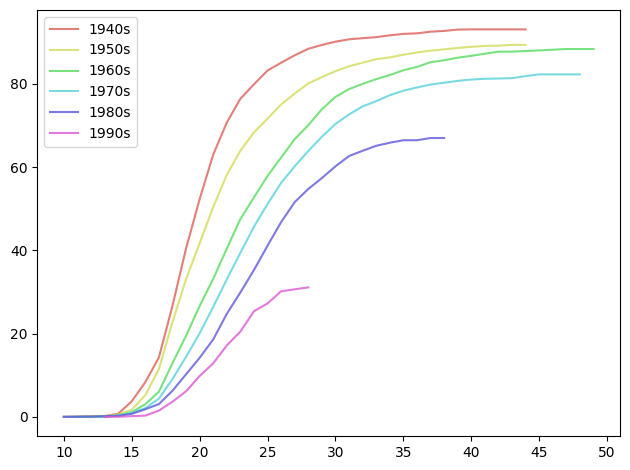

In [9]:
palette = set_palette('hls', 6)
PlotSurvivalFunctions(sf_map)
decorate()

## NSFG corrected analysis

Load the data cleaned in clean_nsfg.ipynb and run the analysis with `lifelines`

In [10]:
%time unweighted = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
unweighted.shape

CPU times: user 54.9 ms, sys: 11.1 ms, total: 66 ms
Wall time: 1.17 s


(70183, 45)

In [11]:
dfs = []

np.random.seed(random_seed)
for name, group in unweighted.groupby('cycle'):
    df = resample_rows_weighted(group, 'finalwgt')
    dfs.append(df)
    
nsfg_female = pd.concat(dfs).reset_index(drop=True)

In [12]:
evrmarry = nsfg_female['evrmarry']
values(evrmarry)

evrmarry
False    30192
True     39991
Name: count, dtype: int64

In [13]:
invalid = evrmarry & nsfg_female['agemarry'].isna()
invalid.sum()

67

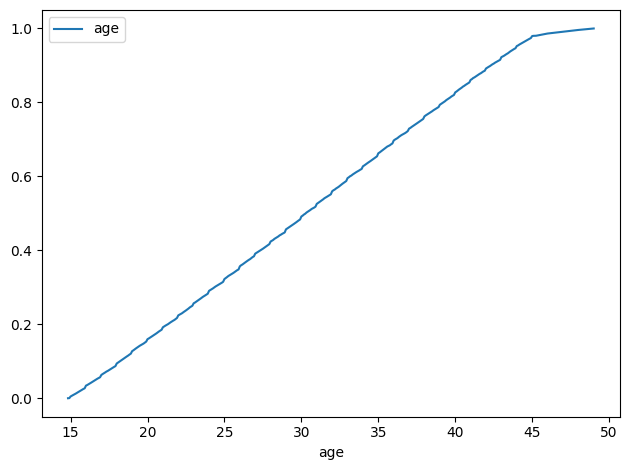

In [14]:
cdf = Cdf.from_seq(nsfg_female['age'], name='age')
cdf.plot()
decorate()

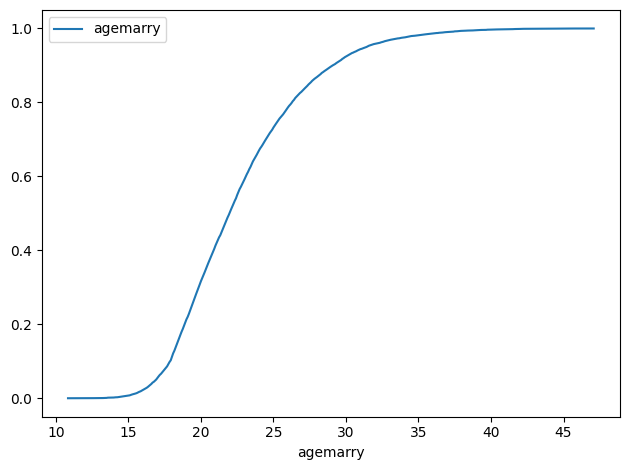

In [15]:
cdf = Cdf.from_seq(nsfg_female['agemarry'], name='agemarry')
cdf.plot()
decorate()

In [16]:
nsfg_female['observed'] = nsfg_female['evrmarry']
nsfg_female.loc[evrmarry, 'duration'] = nsfg_female['agemarry']
nsfg_female.loc[~evrmarry, 'duration'] = nsfg_female['age']

In [17]:
values(nsfg_female['birth_index'])

birth_index
30       323
40      4014
50     10381
60     15638
70     17170
80     13793
90      7835
100     1029
Name: count, dtype: int64

In [18]:
def make_kmf_map(grouped):
    kmf_map = {}

    for cohort, group in grouped:
        kmf = KaplanMeierFitter()
        kmf.fit(group['duration'], group['observed'])
        series = (1 - kmf.survival_function_['KM_estimate']) * 100
        series.name = cohort
        kmf_map[cohort] = series
        
    return kmf_map

In [19]:
grouped = nsfg_female.dropna(subset='duration').groupby('birth_index')
nsfg_map = make_kmf_map(grouped)

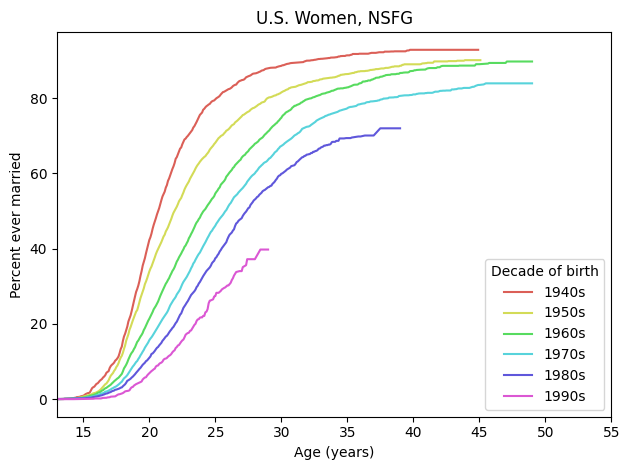

In [20]:
cohorts = range(40, 100, 10)
plot_kmf_map(nsfg_map, cohorts, title='U.S. Women, NSFG')

## NSFG time between marriages

In [21]:
values(nsfg_female['cycle'])

cycle
3      7969
4      8450
5     10847
6      7643
7     12279
8      5601
9      5699
10     5554
11     6141
Name: count, dtype: int64

In the last two cycles, the `mardat` variables are in years rather than century-months.

In [22]:
subset = nsfg_female.query('cycle <= 9')

In [23]:
subset['mardat01'].notna().sum()

16635

In [24]:
subset['mardat02'].notna().sum()

902

In [25]:
subset['mardat03'].notna().sum()

91

In [26]:
subset['mardat04'].notna().sum()

19

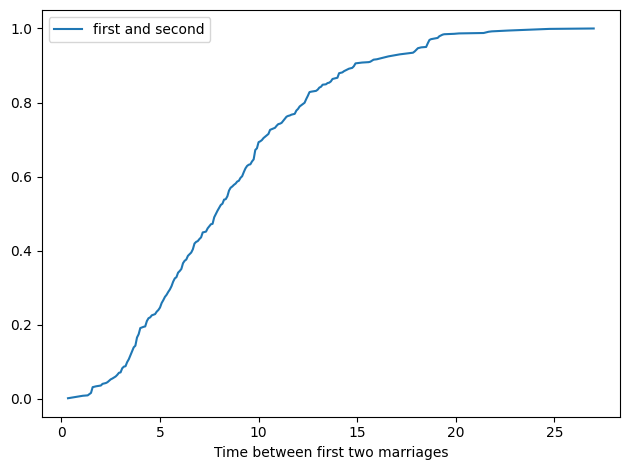

In [27]:
time_between_two = (subset['mardat02'] - subset['mardat01']) / 12
pmf_two = Pmf.from_seq(time_between_two, name='first and second')
pmf_two.make_cdf().plot()
decorate(xlabel='Time between first two marriages')

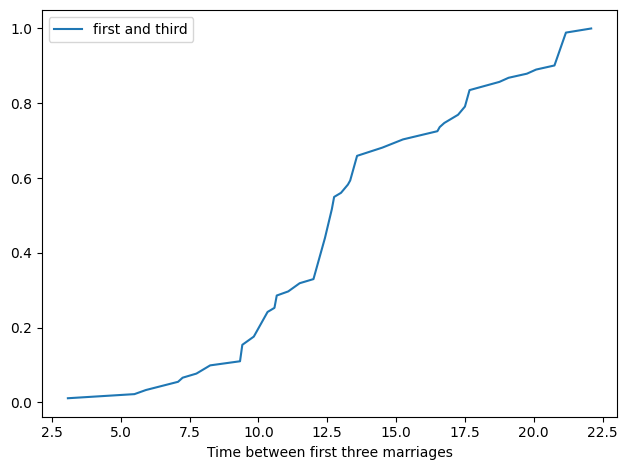

In [28]:
time_between_three = (subset['mardat03'] - subset['mardat01']) / 12
pmf_three = Pmf.from_seq(time_between_three, name='first and third')
pmf_three.make_cdf().plot()
decorate(xlabel='Time between first three marriages')

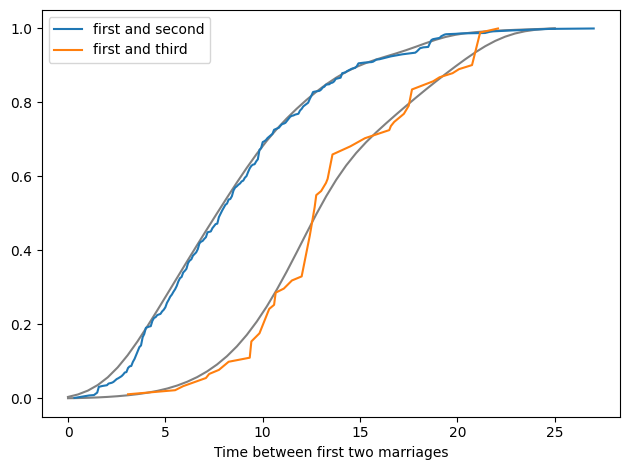

In [29]:
from scipy.stats import gaussian_kde

kde_two = gaussian_kde(time_between_two.dropna())
kde_three = gaussian_kde(time_between_three.dropna())

qs = np.linspace(0, 25)
ps = kde_two(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.make_cdf().plot(color='gray')

ps = kde_three(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.make_cdf().plot(color='gray')

pmf_two.make_cdf().plot()
pmf_three.make_cdf().plot()
decorate(xlabel='Time between first two marriages')

In [30]:
np.percentile(time_between_two.dropna(), [50])

array([7.91666667])

In [31]:
np.percentile(time_between_three.dropna(), [50])

array([12.66666667])

## IPUMS data

Includes 10% sample from years 2008-2022, excluding 2020.

2008 is the first year that includes MARRNO and YRMARR.

2020 uses "experimental weights" to correct for the effect of the pandemic on data collection

In [32]:
unweighted = pd.read_csv('usa_00002.csv.gz')
unweighted.shape

(4421014, 17)

In [33]:
unweighted.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,SEX,AGE,BIRTHQTR,MARST,BIRTHYR,MARRNO,YRMARR
0,2008,200801,11,451,741.48,2008000000111,90301,1,1,731.46,1,35,4,1,1973,1,1999
1,2008,200801,11,451,741.48,2008000000111,90301,1,2,601.20,2,32,1,1,1976,1,1999
2,2008,200801,11,451,741.48,2008000000111,90301,1,3,851.70,1,3,4,6,2005,0,0
3,2008,200801,11,451,741.48,2008000000111,90301,1,4,861.72,1,0,4,6,2008,0,0
4,2008,200801,21,1441,270.54,2008000000211,180001,1,1,260.52,1,50,3,4,1958,1,1986


Resample

In [34]:
np.random.seed(random_seed)
df = resample_rows_weighted(unweighted, 'PERWT').reset_index(drop=True)

In [35]:
df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,SEX,AGE,BIRTHQTR,MARST,BIRTHYR,MARRNO,YRMARR
0,2010,201001,344770,1242943,609.39,2010003447701,210412,1,3,689.31,1,18,2,6,1992,0,0
1,2018,201801,668078,2018000899530,329.67,2018006680781,10026,1,1,319.68,2,65,3,1,1953,1,1972
2,2011,201101,1137184,1046490,727.81,2011011371841,130247,1,3,757.72,1,13,3,6,1998,0,0
3,2015,201501,870801,1118401,1976.04,2015008708011,411336,1,2,1976.04,1,59,2,1,1956,1,1989
4,2008,200801,276573,308084,601.20,2008002765731,370212,1,2,480.96,2,56,2,1,1952,2,1990


In [36]:
values(df['YEAR'])

YEAR
2008    299410
2009    302983
2010    306569
2011    308061
2012    311020
2013    311509
2014    317721
2015    317237
2016    321294
2017    321932
2018    322854
2019    323509
2021    326095
2022    330820
Name: count, dtype: int64

In [37]:
values(df['SEX'])

SEX
1    2179525
2    2241489
Name: count, dtype: int64

In [38]:
df['AGE'].isna().sum()

0

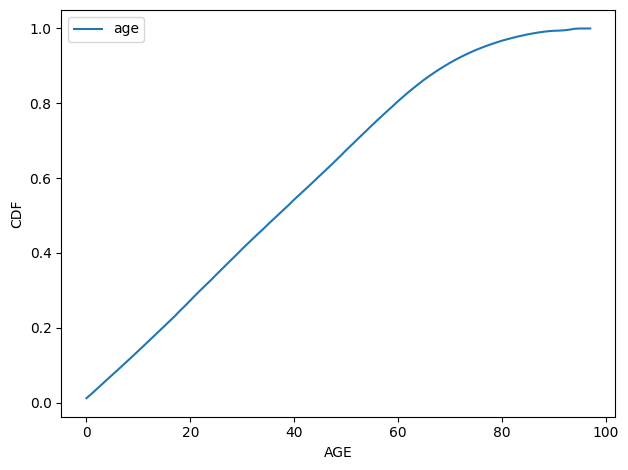

In [39]:
cdf_age = Cdf.from_seq(df['AGE'], name='age')
cdf_age.plot()
decorate(ylabel='CDF')

In [40]:
df['BIRTHYR'].isna().sum()

0

In [41]:
df['BIRTHYR'].describe()

count    4.421014e+06
mean     1.976567e+03
std      2.323732e+01
min      1.913000e+03
25%      1.959000e+03
50%      1.978000e+03
75%      1.996000e+03
max      2.022000e+03
Name: BIRTHYR, dtype: float64

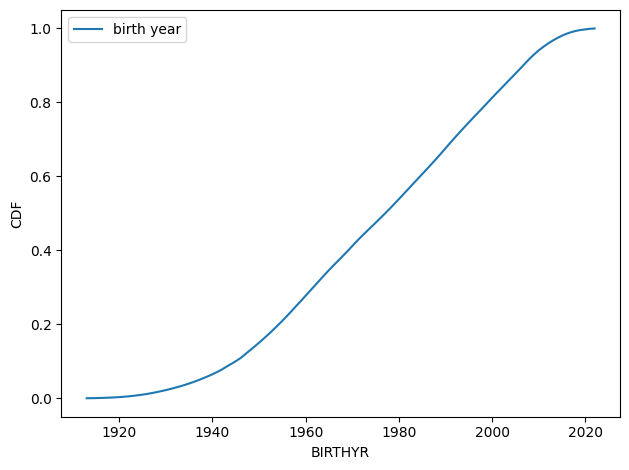

In [42]:
cdf_birthyr = Cdf.from_seq(df['BIRTHYR'], name='birth year')
cdf_birthyr.plot()
decorate(ylabel='CDF')

In [43]:
values(df['MARRNO'])

MARRNO
0    2033496
1    1805405
2     457689
3     124424
Name: count, dtype: int64

In [44]:
married0 = df['MARRNO'] == 0
married0.mean()

0.45996144775836495

In [45]:
married1 = df['MARRNO'] == 1
married1.mean()

0.4083689850337502

In [46]:
married2 = df['MARRNO'] == 2
married2.mean()

0.1035257974754208

`married3` actually means three or more times

In [47]:
married3 = df['MARRNO'] == 3
married3.mean()

0.028143769732464092

In [48]:
df['cohort10'] = round_into_bins(df, 'BIRTHYR', 10) - 1900

In [49]:
millennial1 = df['BIRTHYR'].between(1981, 1988)
millennial1.sum()

480383

In [50]:
millennial2 = df['BIRTHYR'].between(1989, 1995)
millennial2.sum()

436541

In [51]:
genz1 = df['BIRTHYR'].between(1996, 2003)
genz1.sum()

467955

In [52]:
genz2 = df['BIRTHYR'].between(2004, 2012)
genz2.sum()

474873

In [53]:
df['gen'] = np.nan
df.loc[millennial1, 'gen'] = 1
df.loc[millennial2, 'gen'] = 2
df.loc[genz1, 'gen'] = 3
df.loc[genz2, 'gen'] = 4

In [54]:
values(df['gen'])

gen
1.0     480383
2.0     436541
3.0     467955
4.0     474873
NaN    2561262
Name: count, dtype: int64

Set up the values we need for Kaplan-Meier estimation

In [55]:
df['agemarr'] = df['YRMARR'] - df['BIRTHYR']
df['duration'] = np.nan
df['observed'] = np.nan

In [56]:
df.loc[married0, 'duration'] = df.loc[married0, 'AGE']
df.loc[married0, 'observed'] = 0

In [57]:
df.loc[married1, 'duration'] = df.loc[married1, 'agemarr']
df.loc[married1, 'observed'] = 1

For people married more than once, `YRMARR` is the year of the *last marriage*, so we have to treat year of first marriage as missing data.

In [97]:
def fill_missing(df):
    df['filled'] = np.nan

    for cohort in range(10, 110, 10):
        # find people in this cohort who have been married once
        donors = (df['cohort10'] == cohort) & (df['MARRNO'] == 1)

        # select their ages when married
        agemarr = df.loc[donors, 'agemarr']
        low, high = np.percentile(agemarr, [2, 98])
        index = agemarr.between(low, high)

        # find people in this cohort married more than once 
        missing = (df['cohort10'] == cohort) & (df['MARRNO'] > 1)
        n = missing.sum()

        # fill missing data with a random sample
        sample = np.random.choice(agemarr[index], size=n, replace=True)
        df.loc[missing, 'filled'] = sample

In [98]:
np.random.seed(random_seed)
fill_missing(df)
df['filled'].describe()

count    582113.000000
mean         25.688171
std           6.746906
min          15.000000
25%          21.000000
50%          24.000000
75%          29.000000
max          66.000000
Name: filled, dtype: float64

In [110]:
df.loc[married2, 'duration'] = np.minimum(df.loc[married2, 'filled'], 
                                          df.loc[married2, 'agemarr'])
df.loc[married2, 'observed'] = 1

In [111]:
df.loc[married3, 'duration'] = np.minimum(df.loc[married3, 'filled'], 
                                          df.loc[married3, 'agemarr'])
df.loc[married3, 'observed'] = 1

In [112]:
df['duration'].isna().sum()

0

In [113]:
agemarr_cdf = Cdf.from_seq(df['agemarr'])

In [114]:
subset = df.query('cohort10 == 50')
values(subset['MARRNO'])

MARRNO
0     55015
1    329901
2    122644
3     40405
Name: count, dtype: int64

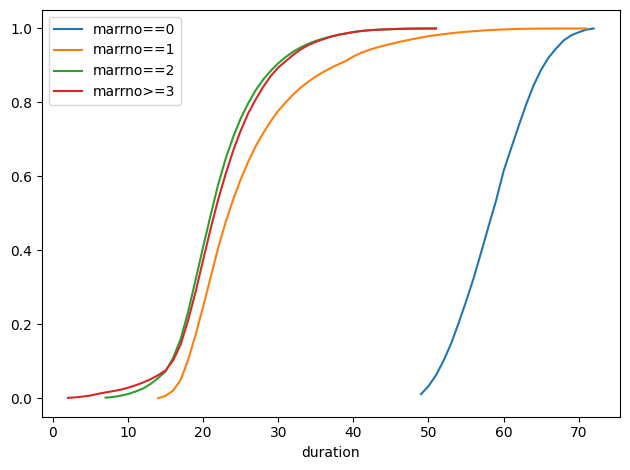

In [115]:
Cdf.from_seq(subset.loc[married0, 'duration']).plot(label='marrno==0')
Cdf.from_seq(subset.loc[married1, 'duration']).plot(label='marrno==1')
Cdf.from_seq(subset.loc[married2, 'duration']).plot(label='marrno==2')
Cdf.from_seq(subset.loc[married3, 'duration']).plot(label='marrno>=3')
decorate()

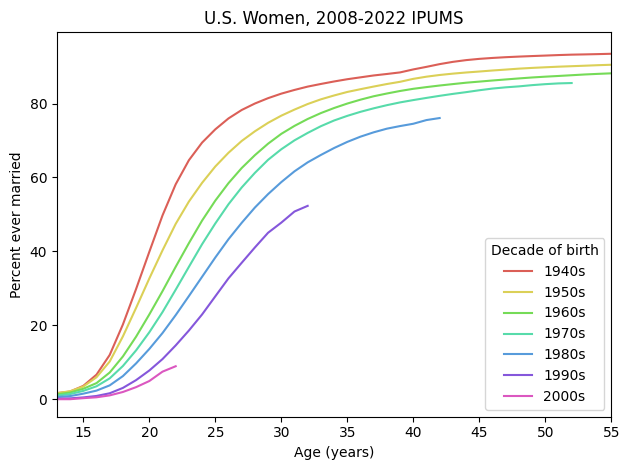

In [116]:
grouped = df.query('SEX==2').groupby('cohort10')
kmf_map = make_kmf_map(grouped)

cohorts = range(40, 110, 10)
plot_kmf_map(kmf_map, cohorts, title='U.S. Women, 2008-2022 IPUMS')

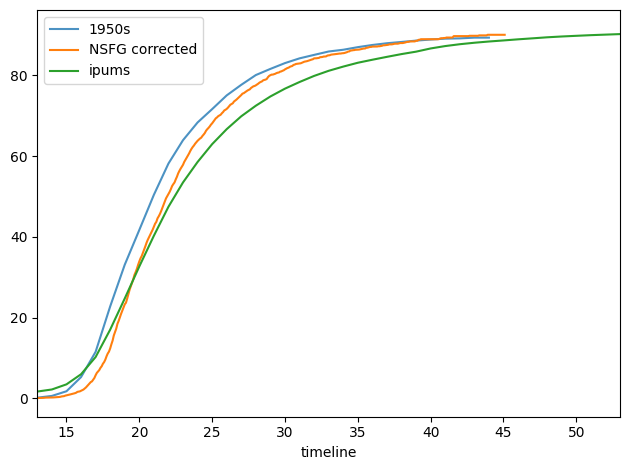

In [117]:
cohort = 50
sf_map_subset = {key: sf_map[key] for key in [cohort] if key in sf_map}
PlotSurvivalFunctions(sf_map_subset)

nsfg_map[cohort].plot(label='NSFG corrected')
kmf_map[cohort].plot(label='ipums')

decorate(xlim=[13, 53])

Now the men

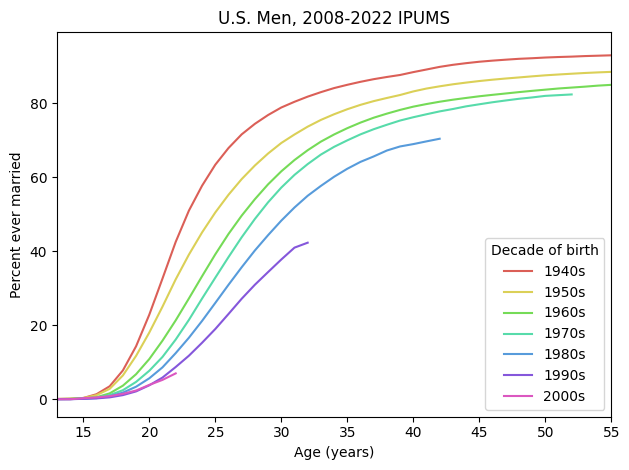

In [107]:
grouped = df.query('SEX==1').groupby('cohort10')
kmf_map = make_kmf_map(grouped)
plot_kmf_map(kmf_map, cohorts, title='U.S. Men, 2008-2022 IPUMS')

The male and female curves are substantially different

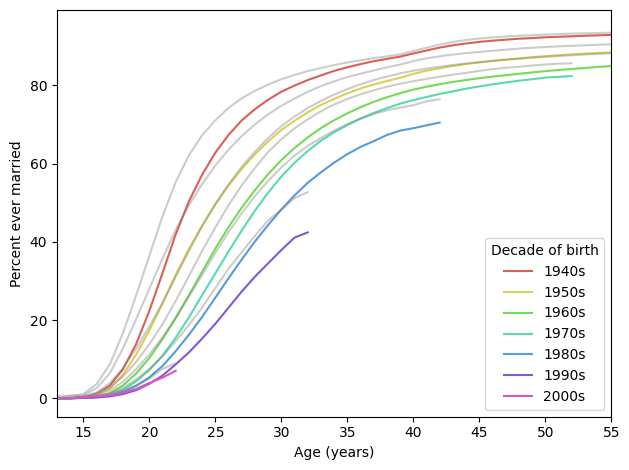

In [68]:
grouped = df.query('SEX==2').groupby('cohort10')
kmf_map2 = make_kmf_map(grouped)

fig, ax = plt.subplots()
palette = set_palette('hls', len(cohorts))
for cohort in cohorts:
    series = kmf_map2[cohort]
    series.plot(ax=ax, label='', color='gray', alpha=0.4)
    series = kmf_map[cohort]
    series.plot(ax=ax, label=f'{cohort+1900}s')

decorate(xlabel='Age (years)',
         ylabel='Percent ever married',
         xlim=[13, 55]
         )

ax.legend(title='Decade of birth', loc='lower right');

I thought the old people might cause a problem, but they don't.

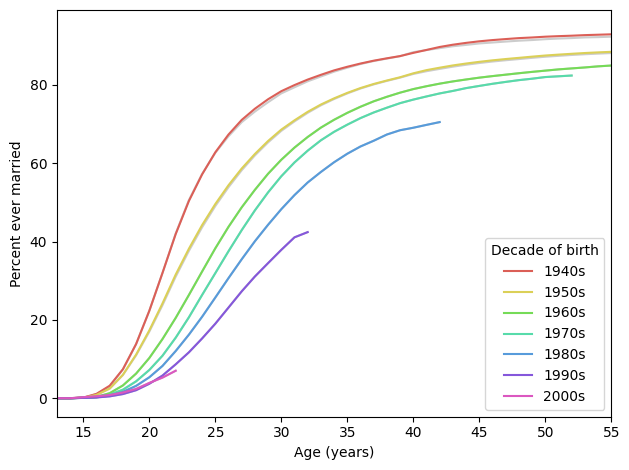

In [69]:
grouped = df.query('AGE<=65 and SEX==1').groupby('cohort10')
kmf_map2 = make_kmf_map(grouped)

fig, ax = plt.subplots()
palette = set_palette('hls', len(cohorts))
for cohort in cohorts:
    series = kmf_map2[cohort]
    series.plot(ax=ax, label='', color='gray', alpha=0.4)
    series = kmf_map[cohort]
    series.plot(ax=ax, label=f'{cohort+1900}s')

decorate(xlabel='Age (years)',
         ylabel='Percent ever married',
         xlim=[13, 55]
         )

ax.legend(title='Decade of birth', loc='lower right');